# Imports

In [1]:
import os
import ipdb
import argparse
import numpy as np
import pandas as pd
import numpy.random as random
from progressbar import ProgressBar
import matplotlib.pyplot as plt
import gzip
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import json
pd.options.display.max_columns = 9999999

In [3]:
data = []

with gzip.open('movielens_5_injected_H1000.json.gz', 'rt', encoding='utf-16') as f:
    for line in f:
        data.append(json.loads(line))

In [4]:
len(data)

105000

In [5]:
print(data[0])
print(data[1])
print(data[2])
print(data[3])
print(data[4])

{'t': 874724710, 'u': 'bottom_255', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'H', 'history_size': 1000, 'bip': True, 'cost': 0.0}
{'t': 874724727, 'u': 'bottom_286', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'H', 'history_size': 1000, 'bip': True, 'cost': 0.0}
{'t': 874724754, 'u': 'bottom_298', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'H', 'history_size': 1000, 'bip': True, 'cost': 0.0}
{'t': 874724781, 'u': 'bottom_185', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'H', 'history_size': 1000, 'bip': True, 'cost': 0.0}
{'t': 874724843, 'u': 'bottom_173', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'H', 'history_size': 1000, 'bip': True, 'cost': 0.0}


# Flatten the internal `O(1)` features

In [6]:
from utilitiesMe import flatten_dict

In [7]:
data_flattened = []
for row in data:
    data_flattened.append(flatten_dict(row))

In [8]:
data_flattened[0]

{'t': 874724710,
 'u': 'bottom_255',
 'v': 'top_259',
 'is_fraud': 0,
 'history_type': 'H',
 'history_size': 1000,
 'bip': True,
 'cost': 0.0}

# Convert flattened json to dataframe

In [9]:
df = pd.DataFrame.from_dict(data_flattened, orient='columns')

In [10]:
df

,t,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,H,1000,True,0.0,628.0,386.0,148.0,1.0,8.0,1.0,386.0,148.0,1.0,8.0,1.0,76.0,51.0,5.0,1.0,196.0,1.0,51.0,5.0,1.0,196.0,1.0,8.0,17.0,2.0,1.0,0.0,9.0,8.0,17.0,2.0,1.0,0.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
104996,893286638,bottom_328,top_729,0,H,1000,True,0.0,627.0,385.0,148.0,1.0,8.0,1.0,385.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,4.0,18.0,14.0,1.0,8.0,9.0,4.0,18.0,14.0,1.0,8.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
104997,893286638,bottom_333,top_729,0,H,1000,True,0.0,627.0,385.0,148.0,1.0,8.0,1.0,385.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,4.0,19.0,15.0,1.0,8.0,9.0,4.0,19.0,15.0,1.0,8.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
104998,893286638,bottom_689,top_729,0,H,1000,True,0.0,628.0,386.0,148.0,1.0,8.0,1.0,386.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,1.0,20.0,386.0,1.0,242.0,9.0,1.0,20.0,386.0,1.0,242.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0


In [11]:
df.rename(columns={'t': 'timestamp'}, inplace=True)
df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,H,1000,True,0.0,628.0,386.0,148.0,1.0,8.0,1.0,386.0,148.0,1.0,8.0,1.0,76.0,51.0,5.0,1.0,196.0,1.0,51.0,5.0,1.0,196.0,1.0,8.0,17.0,2.0,1.0,0.0,9.0,8.0,17.0,2.0,1.0,0.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
104996,893286638,bottom_328,top_729,0,H,1000,True,0.0,627.0,385.0,148.0,1.0,8.0,1.0,385.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,4.0,18.0,14.0,1.0,8.0,9.0,4.0,18.0,14.0,1.0,8.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
104997,893286638,bottom_333,top_729,0,H,1000,True,0.0,627.0,385.0,148.0,1.0,8.0,1.0,385.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,4.0,19.0,15.0,1.0,8.0,9.0,4.0,19.0,15.0,1.0,8.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
104998,893286638,bottom_689,top_729,0,H,1000,True,0.0,628.0,386.0,148.0,1.0,8.0,1.0,386.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,1.0,20.0,386.0,1.0,242.0,9.0,1.0,20.0,386.0,1.0,242.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0


In [12]:
df.describe()

,timestamp,is_fraud,history_size,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,1.050000e+05,105000.000000,105000.0,1.050000e+05,104000.000000,104000.000000,104000.000000,104000.0,104000.000000,104000.000000,104000.000000,104000.000000,104000.0,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.0,104000.000000,104000.00000,104000.000000,104000.000000,104000.0,104000.000000,104000.00000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.0,104000.000000,104000.000000,104000.0,104000.000000,104000.0,104000.000000,104000.000000,104000.000000
mean,8.835258e+08,0.047619,1000.0,2.976190e-07,576.964587,336.689529,135.209856,1.0,7.837154,1.011548,336.689529,135.200317,1.0,7.837154,1.011548,68.741365,47.354923,3.129538,1.0,234.849240,1.00224,47.354923,3.129538,1.0,234.853173,1.00224,2.551452,72.491115,160.549625,4.251375,115.063981,7.700808,2.551538,72.492606,160.545740,4.251337,115.065327,7.700673,999.980135,1000.0,999.960269,0.019865,1.0,1.019865,1.0,1.000038,999.921923,0.019827
std,5.345223e+06,0.212960,0.0,6.819277e-05,47.261353,51.653579,19.385146,0.0,1.908598,0.106840,51.653579,19.391103,0.0,1.908598,0.106840,11.694335,8.004915,2.269882,0.0,85.455625,0.04728,8.004915,2.269882,0.0,85.451144,0.04728,1.640138,80.839889,133.971789,11.752688,92.326534,6.808743,1.640199,80.839437,133.973369,11.752697,92.326723,6.808663,0.139538,0.0,0.279077,0.139538,0.0,0.139538,0.0,0.006202,6.201470,0.139406
min,8.747247e+08,0.000000,1000.0,0.000000e+00,431.000000,205.000000,73.000000,1.0,3.000000,1.000000,205.000000,73.000000,1.0,3.000000,1.000000,25.000000,17.000000,0.000000,1.0,82.000000,1.00000,17.000000,0.000000,1.0,82.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,999.000000,1000.0,998.000000,0.000000,1.0,1.000000,1.0,1.000000,1.000000,0.000000
25%,8.794484e+08,0.000000,1000.0,0.000000e+00,546.000000,303.000000,122.000000,1.0,6.000000,1.000000,303.000000,122.000000,1.0,6.000000,1.000000,61.000000,42.000000,1.000000,1.0,171.000000,1.00000,42.000000,1.000000,1.0,171.000000,1.00000,1.000000,15.000000,50.000000,1.000000,31.000000,2.000000,1.000000,15.000000,50.000000,1.000000,31.000000,2.000000,1000.000000,1000.0,1000.000000,0.000000,1.0,1.000000,1.0,1.000000,1000.000000,0.000000
50%,8.828265e+08,0.000000,1000.0,0.000000e+00,573.000000,330.000000,134.000000,1.0,8.000000,1.000000,330.000000,134.000000,1.0,8.000000,1.000000,69.000000,47.000000,3.000000,1.0,222.000000,1.00000,47.000000,3.000000,1.0,222.000000,1.00000,2.000000,44.000000,128.000000,1.000000,99.000000,6.000000,2.000000,44.000000,128.000000,1.000000,99.000000,6.000000,1000.000000,1000.0,1000.000000,0.000000,1.0,1.000000,1.0,1.000000,1000.000000,0.000000
75%,8.882664e+08,0.000000,1000.0,0.000000e+00,602.000000,361.000000,148.000000,1.0,9.000000,1.000000,361.000000,148.000000,1.0,9.000000,1.000000,76.000000,53.000000,5.000000,1.0,276.000000,1.00000,53.000000,5.000000,1.0,276.000000,1.00000,3.000000,104.000000,301.000000,1.000000,231.000000,

# Remove NaNs

In [13]:
df.head(10)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,874724882,bottom_108,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,874724882,bottom_772,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,874724905,bottom_288,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,874724937,bottom_928,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,874724988,bottom_117,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Create a new DataFrame to preserve rows with NaN
nan_df = pd.DataFrame(columns=df.columns)

# Remove rows with NaN from 'df' and append them to 'nan_df'
nan_rows = df[df.isnull().any(axis=1)]
df = df.dropna()
nan_df = nan_df.append(nan_rows)

# Display the updated 'df' and 'nan_df'
print("Updated DataFrame without NaN:")
df

Updated DataFrame without NaN:


,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
1000,874813703,bottom_293,top_157,0,H,1000,True,0.0,594.0,347.0,151.0,1.0,8.0,1.0,347.0,151.0,1.0,8.0,1.0,54.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,2.0,7.0,151.0,1.0,96.0,11.0,2.0,7.0,151.0,1.0,96.0,11.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
1001,874815541,bottom_258,top_817,0,H,1000,True,0.0,594.0,346.0,153.0,1.0,8.0,1.0,346.0,153.0,1.0,8.0,1.0,55.0,43.0,0.0,1.0,362.0,1.0,43.0,0.0,1.0,362.0,1.0,2.0,1.0,153.0,43.0,95.0,12.0,2.0,1.0,153.0,43.0,95.0,12.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
1002,874815542,bottom_300,top_817,0,H,1000,True,0.0,594.0,346.0,153.0,1.0,8.0,1.0,346.0,153.0,1.0,8.0,1.0,55.0,42.0,1.0,1.0,362.0,1.0,42.0,1.0,1.0,362.0,1.0,3.0,2.0,54.0,1.0,41.0,12.0,3.0,2.0,54.0,1.0,41.0,12.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
1003,874815542,bottom_876,top_817,0,H,1000,True,0.0,595.0,347.0,154.0,1.0,8.0,1.0,347.0,154.0,1.0,8.0,1.0,55.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,1.0,3.0,347.0,1.0,248.0,12.0,1.0,3.0,347.0,1.0,248.0,12.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
1004,874815593,bottom_288,top_817,0,H,1000,True,0.0,595.0,347.0,154.0,1.0,8.0,1.0,347.0,154.0,1.0,8.0,1.0,55.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,4.0,4.0,25.0,1.0,16.0,12.0,4.0,4.0,25.0,1.0,16.0,12.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,H,1000,True,0.0,628.0,386.0,148.0,1.0,8.0,1.0,386.0,148.0,1.0,8.0,1.0,76.0,51.0,5.0,1.0,196.0,1.0,51.0,5.0,1.0,196.0,1.0,8.0,17.0,2.0,1.0,0.0,9.0,8.0,17.0,2.0,1.0,0.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
104996,893286638,bottom_328,top_729,0,H,1000,True,0.0,627.0,385.0,148.0,1.0,8.0,1.0,385.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,4.0,18.0,14.0,1.0,8.0,9.0,4.0,18.0,14.0,1.0,8.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
104997,893286638,bottom_333,top_729,0,H,1000,True,0.0,627.0,385.0,148.0,1.0,8.0,1.0,385.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,4.0,19.0,15.0,1.0,8.0,9.0,4.0,19.0,15.0,1.0,8.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
104998,893286638,bottom_689,top_729,0,H,1000,True,0.0,628.0,386.0,148.0,1.0,8.0,1.0,386.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,1.0,20.0,386.0,1.0,242.0,9.0,1.0,20.0,386.0,1.0,242.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0


In [15]:
nan_df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,874813477,bottom_515,top_157,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,874813703,bottom_1,top_157,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,874813703,bottom_1302,top_157,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,874813703,bottom_150,top_157,0,H,1000,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.describe()

,timestamp,is_fraud,history_size,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,1.040000e+05,104000.000000,104000.0,1.040000e+05,104000.000000,104000.000000,104000.000000,104000.0,104000.000000,104000.000000,104000.000000,104000.000000,104000.0,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.0,104000.000000,104000.00000,104000.000000,104000.000000,104000.0,104000.000000,104000.00000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.0,104000.000000,104000.000000,104000.0,104000.000000,104000.0,104000.000000,104000.000000,104000.000000
mean,8.836099e+08,0.047654,1000.0,3.004808e-07,576.964587,336.689529,135.209856,1.0,7.837154,1.011548,336.689529,135.200317,1.0,7.837154,1.011548,68.741365,47.354923,3.129538,1.0,234.849240,1.00224,47.354923,3.129538,1.0,234.853173,1.00224,2.551452,72.491115,160.549625,4.251375,115.063981,7.700808,2.551538,72.492606,160.545740,4.251337,115.065327,7.700673,999.980135,1000.0,999.960269,0.019865,1.0,1.019865,1.0,1.000038,999.921923,0.019827
std,5.301300e+06,0.213034,0.0,6.851983e-05,47.261353,51.653579,19.385146,0.0,1.908598,0.106840,51.653579,19.391103,0.0,1.908598,0.106840,11.694335,8.004915,2.269882,0.0,85.455625,0.04728,8.004915,2.269882,0.0,85.451144,0.04728,1.640138,80.839889,133.971789,11.752688,92.326534,6.808743,1.640199,80.839437,133.973369,11.752697,92.326723,6.808663,0.139538,0.0,0.279077,0.139538,0.0,0.139538,0.0,0.006202,6.201470,0.139406
min,8.748137e+08,0.000000,1000.0,0.000000e+00,431.000000,205.000000,73.000000,1.0,3.000000,1.000000,205.000000,73.000000,1.0,3.000000,1.000000,25.000000,17.000000,0.000000,1.0,82.000000,1.00000,17.000000,0.000000,1.0,82.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,999.000000,1000.0,998.000000,0.000000,1.0,1.000000,1.0,1.000000,1.000000,0.000000
25%,8.794561e+08,0.000000,1000.0,0.000000e+00,546.000000,303.000000,122.000000,1.0,6.000000,1.000000,303.000000,122.000000,1.0,6.000000,1.000000,61.000000,42.000000,1.000000,1.0,171.000000,1.00000,42.000000,1.000000,1.0,171.000000,1.00000,1.000000,15.000000,50.000000,1.000000,31.000000,2.000000,1.000000,15.000000,50.000000,1.000000,31.000000,2.000000,1000.000000,1000.0,1000.000000,0.000000,1.0,1.000000,1.0,1.000000,1000.000000,0.000000
50%,8.829123e+08,0.000000,1000.0,0.000000e+00,573.000000,330.000000,134.000000,1.0,8.000000,1.000000,330.000000,134.000000,1.0,8.000000,1.000000,69.000000,47.000000,3.000000,1.0,222.000000,1.00000,47.000000,3.000000,1.0,222.000000,1.00000,2.000000,44.000000,128.000000,1.000000,99.000000,6.000000,2.000000,44.000000,128.000000,1.000000,99.000000,6.000000,1000.000000,1000.0,1000.000000,0.000000,1.0,1.000000,1.0,1.000000,1000.000000,0.000000
75%,8.883599e+08,0.000000,1000.0,0.000000e+00,602.000000,361.000000,148.000000,1.0,9.000000,1.000000,361.000000,148.000000,1.0,9.000000,1.000000,76.000000,53.000000,5.000000,1.0,276.000000,1.00000,53.000000,5.000000,1.0,276.000000,1.00000,3.000000,104.000000,301.000000,1.000000,231.000000,

In [17]:
df_features = df.drop(["timestamp",
                       "u",
                       "v", 
                        "history_type", 
                        "bip", 
                        "cost", # cost of O1 features
                        "history_size"], axis="columns")
df_features

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
1000,0,594.0,347.0,151.0,1.0,8.0,1.0,347.0,151.0,1.0,8.0,1.0,54.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,2.0,7.0,151.0,1.0,96.0,11.0,2.0,7.0,151.0,1.0,96.0,11.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
1001,0,594.0,346.0,153.0,1.0,8.0,1.0,346.0,153.0,1.0,8.0,1.0,55.0,43.0,0.0,1.0,362.0,1.0,43.0,0.0,1.0,362.0,1.0,2.0,1.0,153.0,43.0,95.0,12.0,2.0,1.0,153.0,43.0,95.0,12.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
1002,0,594.0,346.0,153.0,1.0,8.0,1.0,346.0,153.0,1.0,8.0,1.0,55.0,42.0,1.0,1.0,362.0,1.0,42.0,1.0,1.0,362.0,1.0,3.0,2.0,54.0,1.0,41.0,12.0,3.0,2.0,54.0,1.0,41.0,12.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
1003,0,595.0,347.0,154.0,1.0,8.0,1.0,347.0,154.0,1.0,8.0,1.0,55.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,1.0,3.0,347.0,1.0,248.0,12.0,1.0,3.0,347.0,1.0,248.0,12.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
1004,0,595.0,347.0,154.0,1.0,8.0,1.0,347.0,154.0,1.0,8.0,1.0,55.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,4.0,4.0,25.0,1.0,16.0,12.0,4.0,4.0,25.0,1.0,16.0,12.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,0,628.0,386.0,148.0,1.0,8.0,1.0,386.0,148.0,1.0,8.0,1.0,76.0,51.0,5.0,1.0,196.0,1.0,51.0,5.0,1.0,196.0,1.0,8.0,17.0,2.0,1.0,0.0,9.0,8.0,17.0,2.0,1.0,0.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
104996,0,627.0,385.0,148.0,1.0,8.0,1.0,385.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,4.0,18.0,14.0,1.0,8.0,9.0,4.0,18.0,14.0,1.0,8.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
104997,0,627.0,385.0,148.0,1.0,8.0,1.0,385.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,4.0,19.0,15.0,1.0,8.0,9.0,4.0,19.0,15.0,1.0,8.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
104998,0,628.0,386.0,148.0,1.0,8.0,1.0,386.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,1.0,20.0,386.0,1.0,242.0,9.0,1.0,20.0,386.0,1.0,242.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0


In [18]:
df_features.describe()

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,104000.000000,104000.000000,104000.000000,104000.000000,104000.0,104000.000000,104000.000000,104000.000000,104000.000000,104000.0,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.0,104000.000000,104000.00000,104000.000000,104000.000000,104000.0,104000.000000,104000.00000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.000000,104000.0,104000.000000,104000.000000,104000.0,104000.000000,104000.0,104000.000000,104000.000000,104000.000000
mean,0.047654,576.964587,336.689529,135.209856,1.0,7.837154,1.011548,336.689529,135.200317,1.0,7.837154,1.011548,68.741365,47.354923,3.129538,1.0,234.849240,1.00224,47.354923,3.129538,1.0,234.853173,1.00224,2.551452,72.491115,160.549625,4.251375,115.063981,7.700808,2.551538,72.492606,160.545740,4.251337,115.065327,7.700673,999.980135,1000.0,999.960269,0.019865,1.0,1.019865,1.0,1.000038,999.921923,0.019827
std,0.213034,47.261353,51.653579,19.385146,0.0,1.908598,0.106840,51.653579,19.391103,0.0,1.908598,0.106840,11.694335,8.004915,2.269882,0.0,85.455625,0.04728,8.004915,2.269882,0.0,85.451144,0.04728,1.640138,80.839889,133.971789,11.752688,92.326534,6.808743,1.640199,80.839437,133.973369,11.752697,92.326723,6.808663,0.139538,0.0,0.279077,0.139538,0.0,0.139538,0.0,0.006202,6.201470,0.139406
min,0.000000,431.000000,205.000000,73.000000,1.0,3.000000,1.000000,205.000000,73.000000,1.0,3.000000,1.000000,25.000000,17.000000,0.000000,1.0,82.000000,1.00000,17.000000,0.000000,1.0,82.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,999.000000,1000.0,998.000000,0.000000,1.0,1.000000,1.0,1.000000,1.000000,0.000000
25%,0.000000,546.000000,303.000000,122.000000,1.0,6.000000,1.000000,303.000000,122.000000,1.0,6.000000,1.000000,61.000000,42.000000,1.000000,1.0,171.000000,1.00000,42.000000,1.000000,1.0,171.000000,1.00000,1.000000,15.000000,50.000000,1.000000,31.000000,2.000000,1.000000,15.000000,50.000000,1.000000,31.000000,2.000000,1000.000000,1000.0,1000.000000,0.000000,1.0,1.000000,1.0,1.000000,1000.000000,0.000000
50%,0.000000,573.000000,330.000000,134.000000,1.0,8.000000,1.000000,330.000000,134.000000,1.0,8.000000,1.000000,69.000000,47.000000,3.000000,1.0,222.000000,1.00000,47.000000,3.000000,1.0,222.000000,1.00000,2.000000,44.000000,128.000000,1.000000,99.000000,6.000000,2.000000,44.000000,128.000000,1.000000,99.000000,6.000000,1000.000000,1000.0,1000.000000,0.000000,1.0,1.000000,1.0,1.000000,1000.000000,0.000000
75%,0.000000,602.000000,361.000000,148.000000,1.0,9.000000,1.000000,361.000000,148.000000,1.0,9.000000,1.000000,76.000000,53.000000,5.000000,1.0,276.000000,1.00000,53.000000,5.000000,1.0,276.000000,1.00000,3.000000,104.000000,301.000000,1.000000,231.000000,11.000000,3.000000,104.000000,301.000000,1.000000,231.000000,11.000000,1000.000000,1000.0,1000.000000,0.000000,1.0,1.000000,1.0,1.000000,1000.000000,0.000000
max,1.000000,825.000000,682.000000,219.000000,1.0,16.000000,2.000000,682.000000,219.000000,1.0,16.00

In [19]:
df_target = df["is_fraud"]
df_target

1000      0
1001      0
1002      0
1003      0
1004      0
         ..
104995    0
104996    0
104997    0
104998    0
104999    0
Name: is_fraud, Length: 104000, dtype: int64

# Learning Technique #1: Classical + Underasmpling in training only

## $r$ = 0.7
Before undersampling, take 30% for testing then the 70% take it for training and do undersampling on it

In [20]:
percentage=round(len(df)/100*70) 
train_df=df_features.head(percentage)
test_df=df_features.iloc[percentage:len(df_features),:]

In [21]:
len(train_df) + len(test_df) == len(df)

True

In [22]:
train_df

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
1000,0,594.0,347.0,151.0,1.0,8.0,1.0,347.0,151.0,1.0,8.0,1.0,54.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,2.0,7.0,151.0,1.0,96.0,11.0,2.0,7.0,151.0,1.0,96.0,11.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
1001,0,594.0,346.0,153.0,1.0,8.0,1.0,346.0,153.0,1.0,8.0,1.0,55.0,43.0,0.0,1.0,362.0,1.0,43.0,0.0,1.0,362.0,1.0,2.0,1.0,153.0,43.0,95.0,12.0,2.0,1.0,153.0,43.0,95.0,12.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
1002,0,594.0,346.0,153.0,1.0,8.0,1.0,346.0,153.0,1.0,8.0,1.0,55.0,42.0,1.0,1.0,362.0,1.0,42.0,1.0,1.0,362.0,1.0,3.0,2.0,54.0,1.0,41.0,12.0,3.0,2.0,54.0,1.0,41.0,12.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
1003,0,595.0,347.0,154.0,1.0,8.0,1.0,347.0,154.0,1.0,8.0,1.0,55.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,1.0,3.0,347.0,1.0,248.0,12.0,1.0,3.0,347.0,1.0,248.0,12.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
1004,0,595.0,347.0,154.0,1.0,8.0,1.0,347.0,154.0,1.0,8.0,1.0,55.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,4.0,4.0,25.0,1.0,16.0,12.0,4.0,4.0,25.0,1.0,16.0,12.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73795,0,597.0,380.0,120.0,1.0,12.0,1.0,380.0,120.0,1.0,12.0,1.0,89.0,60.0,2.0,1.0,150.0,1.0,60.0,2.0,1.0,150.0,1.0,4.0,10.0,25.0,3.0,19.0,13.0,4.0,10.0,25.0,3.0,19.0,13.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
73796,0,597.0,380.0,120.0,1.0,12.0,1.0,380.0,120.0,1.0,12.0,1.0,89.0,60.0,3.0,1.0,150.0,1.0,60.0,3.0,1.0,150.0,1.0,7.0,11.0,2.0,1.0,3.0,13.0,7.0,11.0,2.0,1.0,3.0,13.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
73797,0,597.0,381.0,119.0,1.0,13.0,1.0,381.0,119.0,1.0,13.0,1.0,90.0,62.0,2.0,1.0,150.0,1.0,62.0,2.0,1.0,150.0,1.0,13.0,1.0,1.0,62.0,0.0,28.0,13.0,1.0,1.0,62.0,0.0,28.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
73798,0,596.0,380.0,118.0,1.0,13.0,1.0,380.0,118.0,1.0,13.0,1.0,89.0,60.0,3.0,1.0,150.0,1.0,60.0,3.0,1.0,150.0,1.0,3.0,2.0,55.0,3.0,43.0,26.0,3.0,2.0,55.0,3.0,43.0,26.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0


In [23]:
test_df

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
73800,0,596.0,380.0,118.0,1.0,13.0,1.0,380.0,118.0,1.0,13.0,1.0,88.0,59.0,2.0,1.0,150.0,1.0,59.0,2.0,1.0,150.0,1.0,1.0,3.0,380.0,5.0,216.0,22.0,1.0,3.0,380.0,5.0,216.0,22.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
73801,0,597.0,381.0,118.0,1.0,13.0,1.0,381.0,118.0,1.0,13.0,1.0,87.0,58.0,2.0,1.0,150.0,1.0,58.0,2.0,1.0,150.0,1.0,1.0,4.0,381.0,2.0,216.0,21.0,1.0,4.0,381.0,2.0,216.0,21.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
73802,0,597.0,381.0,118.0,1.0,13.0,1.0,381.0,118.0,1.0,13.0,1.0,86.0,57.0,1.0,1.0,150.0,1.0,57.0,1.0,1.0,150.0,1.0,3.0,3.0,56.0,5.0,42.0,23.0,3.0,3.0,56.0,5.0,42.0,23.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
73803,0,597.0,380.0,119.0,1.0,13.0,1.0,380.0,119.0,1.0,13.0,1.0,86.0,57.0,1.0,1.0,150.0,1.0,57.0,1.0,1.0,150.0,1.0,2.0,5.0,119.0,1.0,98.0,21.0,2.0,5.0,119.0,1.0,98.0,21.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
73804,0,598.0,381.0,119.0,1.0,13.0,1.0,381.0,119.0,1.0,13.0,1.0,86.0,57.0,1.0,1.0,150.0,1.0,57.0,1.0,1.0,150.0,1.0,1.0,6.0,381.0,1.0,217.0,21.0,1.0,6.0,381.0,1.0,217.0,21.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,0,628.0,386.0,148.0,1.0,8.0,1.0,386.0,148.0,1.0,8.0,1.0,76.0,51.0,5.0,1.0,196.0,1.0,51.0,5.0,1.0,196.0,1.0,8.0,17.0,2.0,1.0,0.0,9.0,8.0,17.0,2.0,1.0,0.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
104996,0,627.0,385.0,148.0,1.0,8.0,1.0,385.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,4.0,18.0,14.0,1.0,8.0,9.0,4.0,18.0,14.0,1.0,8.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
104997,0,627.0,385.0,148.0,1.0,8.0,1.0,385.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,4.0,19.0,15.0,1.0,8.0,9.0,4.0,19.0,15.0,1.0,8.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
104998,0,628.0,386.0,148.0,1.0,8.0,1.0,386.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,1.0,20.0,386.0,1.0,242.0,9.0,1.0,20.0,386.0,1.0,242.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0


### Undersampling and training on `X_train, y_train`

In [24]:
train_df["is_fraud"].value_counts()

0    69333
1     3467
Name: is_fraud, dtype: int64

In [25]:
# Separating the data for analysis (they will be Series)
nonanomalous = train_df[train_df.is_fraud == 0]
anomalous = train_df[train_df.is_fraud == 1]

In [26]:
print(len(nonanomalous))
print(len(anomalous))

69333
3467


In [27]:
print(nonanomalous.shape)
print(anomalous.shape)

(69333, 45)
(3467, 45)


In [28]:
# Compare the values for both classes
train_df.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,569.889014,328.869355,133.214876,1.0,7.73571,1.010399,328.869355,133.202112,1.0,7.73571,1.010399,67.809961,47.080020,2.957509,1.0,228.017553,1.0,47.080020,2.957509,1.0,228.023149,1.0,2.637142,73.406588,150.635787,2.140005,111.203352,7.133284,2.637200,73.408045,150.633609,2.139977,111.204679,7.133126,999.984192,1000.0,999.968384,0.015808,1.0,1.015808,1.0,1.000014,999.954005,0.015793
1,569.618979,328.351601,133.173060,1.0,7.75137,1.011537,328.351601,133.159792,1.0,7.75137,1.011537,69.238823,48.334295,3.033747,1.0,226.796654,1.0,48.334295,3.033747,1.0,226.802711,1.0,1.584367,2.114797,247.758869,45.420248,184.572253,20.472743,1.584655,2.115085,247.738102,45.420248,184.558408,20.472743,999.984713,1000.0,999.969426,0.015287,1.0,1.015287,1.0,1.000288,999.681858,0.014999


In [29]:
# Sampling
nonanomalous_sample = nonanomalous.sample(n = len(anomalous), random_state=12)

In [30]:
# Concatenating
new_dataset = pd.concat([nonanomalous_sample, anomalous], axis=0)

In [31]:
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
31983,0,521.0,288.0,121.0,1.0,9.0,1.0,288.0,121.0,1.0,9.0,1.0,72.0,41.0,8.0,1.0,117.0,1.0,41.0,8.0,1.0,117.0,1.0,7.0,39.0,6.0,1.0,6.0,9.0,7.0,39.0,6.0,1.0,6.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
63170,0,600.0,375.0,125.0,1.0,9.0,1.0,375.0,125.0,1.0,9.0,1.0,86.0,51.0,5.0,1.0,264.0,1.0,51.0,5.0,1.0,264.0,1.0,5.0,14.0,10.0,1.0,8.0,13.0,5.0,14.0,10.0,1.0,8.0,13.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
8202,0,603.0,342.0,162.0,1.0,6.0,1.0,342.0,162.0,1.0,6.0,1.0,73.0,54.0,0.0,1.0,161.0,1.0,54.0,0.0,1.0,161.0,1.0,3.0,37.0,67.0,2.0,32.0,8.0,3.0,37.0,67.0,2.0,32.0,8.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
19427,0,551.0,302.0,137.0,1.0,7.0,1.0,302.0,137.0,1.0,7.0,1.0,67.0,49.0,3.0,1.0,191.0,1.0,49.0,3.0,1.0,191.0,1.0,1.0,191.0,302.0,1.0,249.0,0.0,1.0,191.0,302.0,1.0,249.0,0.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
71338,0,583.0,344.0,129.0,1.0,8.0,1.0,344.0,129.0,1.0,8.0,1.0,66.0,42.0,5.0,1.0,222.0,1.0,42.0,5.0,1.0,222.0,1.0,4.0,5.0,33.0,1.0,13.0,15.0,4.0,5.0,33.0,1.0,13.0,15.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73736,1,596.0,379.0,125.0,1.0,11.0,1.0,379.0,125.0,1.0,11.0,1.0,86.0,57.0,2.0,1.0,150.0,1.0,57.0,2.0,1.0,150.0,1.0,2.0,1.0,125.0,57.0,92.0,29.0,2.0,1.0,125.0,57.0,92.0,29.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
73746,1,597.0,376.0,128.0,1.0,11.0,1.0,376.0,128.0,1.0,11.0,1.0,87.0,58.0,2.0,1.0,150.0,1.0,58.0,2.0,1.0,150.0,1.0,1.0,1.0,376.0,58.0,221.0,29.0,1.0,1.0,376.0,58.0,221.0,29.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
73783,1,596.0,377.0,123.0,1.0,12.0,1.0,377.0,123.0,1.0,12.0,1.0,87.0,58.0,2.0,1.0,150.0,1.0,58.0,2.0,1.0,150.0,1.0,1.0,1.0,377.0,58.0,219.0,29.0,1.0,1.0,377.0,58.0,219.0,29.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
73784,1,596.0,377.0,123.0,1.0,12.0,1.0,377.0,123.0,1.0,12.0,1.0,88.0,59.0,2.0,1.0,150.0,1.0,59.0,2.0,1.0,150.0,1.0,1.0,1.0,377.0,59.0,219.0,29.0,1.0,1.0,377.0,59.0,219.0,29.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0


Author: Now the rows of the `nonanomalous` are random

In [32]:
# Now we will check deeper the values on the new dataset and compare them
new_dataset["is_fraud"].value_counts()

0    3467
1    3467
Name: is_fraud, dtype: int64

In [33]:
new_dataset.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,569.276320,327.964811,133.157485,1.0,7.716181,1.010672,327.964811,133.143063,1.0,7.716181,1.010672,67.741852,47.099798,2.946928,1.0,229.249495,1.0,47.099798,2.946928,1.0,229.256995,1.0,2.615518,73.171330,152.317277,2.128641,113.318719,7.135564,2.615806,73.173060,152.310355,2.128065,113.314104,7.135564,999.982117,1000.0,999.964234,0.017883,1.0,1.017883,1.0,1.000000,999.964234,0.017883
1,569.618979,328.351601,133.173060,1.0,7.751370,1.011537,328.351601,133.159792,1.0,7.751370,1.011537,69.238823,48.334295,3.033747,1.0,226.796654,1.0,48.334295,3.033747,1.0,226.802711,1.0,1.584367,2.114797,247.758869,45.420248,184.572253,20.472743,1.584655,2.115085,247.738102,45.420248,184.558408,20.472743,999.984713,1000.0,999.969426,0.015287,1.0,1.015287,1.0,1.000288,999.681858,0.014999


In [34]:
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
31983,0,521.0,288.0,121.0,1.0,9.0,1.0,288.0,121.0,1.0,9.0,1.0,72.0,41.0,8.0,1.0,117.0,1.0,41.0,8.0,1.0,117.0,1.0,7.0,39.0,6.0,1.0,6.0,9.0,7.0,39.0,6.0,1.0,6.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
63170,0,600.0,375.0,125.0,1.0,9.0,1.0,375.0,125.0,1.0,9.0,1.0,86.0,51.0,5.0,1.0,264.0,1.0,51.0,5.0,1.0,264.0,1.0,5.0,14.0,10.0,1.0,8.0,13.0,5.0,14.0,10.0,1.0,8.0,13.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
8202,0,603.0,342.0,162.0,1.0,6.0,1.0,342.0,162.0,1.0,6.0,1.0,73.0,54.0,0.0,1.0,161.0,1.0,54.0,0.0,1.0,161.0,1.0,3.0,37.0,67.0,2.0,32.0,8.0,3.0,37.0,67.0,2.0,32.0,8.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
19427,0,551.0,302.0,137.0,1.0,7.0,1.0,302.0,137.0,1.0,7.0,1.0,67.0,49.0,3.0,1.0,191.0,1.0,49.0,3.0,1.0,191.0,1.0,1.0,191.0,302.0,1.0,249.0,0.0,1.0,191.0,302.0,1.0,249.0,0.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
71338,0,583.0,344.0,129.0,1.0,8.0,1.0,344.0,129.0,1.0,8.0,1.0,66.0,42.0,5.0,1.0,222.0,1.0,42.0,5.0,1.0,222.0,1.0,4.0,5.0,33.0,1.0,13.0,15.0,4.0,5.0,33.0,1.0,13.0,15.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73736,1,596.0,379.0,125.0,1.0,11.0,1.0,379.0,125.0,1.0,11.0,1.0,86.0,57.0,2.0,1.0,150.0,1.0,57.0,2.0,1.0,150.0,1.0,2.0,1.0,125.0,57.0,92.0,29.0,2.0,1.0,125.0,57.0,92.0,29.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
73746,1,597.0,376.0,128.0,1.0,11.0,1.0,376.0,128.0,1.0,11.0,1.0,87.0,58.0,2.0,1.0,150.0,1.0,58.0,2.0,1.0,150.0,1.0,1.0,1.0,376.0,58.0,221.0,29.0,1.0,1.0,376.0,58.0,221.0,29.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
73783,1,596.0,377.0,123.0,1.0,12.0,1.0,377.0,123.0,1.0,12.0,1.0,87.0,58.0,2.0,1.0,150.0,1.0,58.0,2.0,1.0,150.0,1.0,1.0,1.0,377.0,58.0,219.0,29.0,1.0,1.0,377.0,58.0,219.0,29.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
73784,1,596.0,377.0,123.0,1.0,12.0,1.0,377.0,123.0,1.0,12.0,1.0,88.0,59.0,2.0,1.0,150.0,1.0,59.0,2.0,1.0,150.0,1.0,1.0,1.0,377.0,59.0,219.0,29.0,1.0,1.0,377.0,59.0,219.0,29.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0


In [35]:
new_dataset = new_dataset.sample(frac=1, random_state=42)  # frac=1 means we sample 100% of the data
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
10729,1,533.0,308.0,106.0,1.0,9.0,1.0,308.0,106.0,1.0,9.0,1.0,87.0,60.0,2.0,1.0,129.0,1.0,60.0,2.0,1.0,129.0,1.0,1.0,1.0,308.0,60.0,225.0,27.0,1.0,1.0,308.0,60.0,225.0,27.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
55491,0,501.0,271.0,107.0,1.0,13.0,1.0,271.0,107.0,1.0,13.0,1.0,77.0,53.0,4.0,1.0,173.0,1.0,53.0,4.0,1.0,173.0,1.0,1.0,140.0,271.0,1.0,230.0,1.0,1.0,140.0,271.0,1.0,230.0,1.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
47281,0,571.0,335.0,125.0,1.0,7.0,1.0,335.0,125.0,1.0,7.0,1.0,74.0,54.0,3.0,1.0,250.0,1.0,54.0,3.0,1.0,250.0,1.0,1.0,159.0,335.0,1.0,236.0,1.0,1.0,159.0,335.0,1.0,236.0,1.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
19014,1,551.0,306.0,128.0,1.0,9.0,1.0,306.0,128.0,1.0,9.0,1.0,75.0,58.0,0.0,1.0,185.0,1.0,58.0,0.0,1.0,185.0,1.0,1.0,1.0,306.0,58.0,245.0,17.0,1.0,1.0,306.0,58.0,245.0,17.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
24012,1,587.0,357.0,116.0,1.0,8.0,1.0,357.0,116.0,1.0,8.0,1.0,56.0,40.0,0.0,1.0,237.0,1.0,40.0,0.0,1.0,237.0,1.0,1.0,1.0,357.0,40.0,230.0,16.0,1.0,1.0,357.0,40.0,230.0,16.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6974,1,551.0,296.0,140.0,1.0,8.0,1.0,296.0,140.0,1.0,8.0,1.0,86.0,62.0,3.0,1.0,210.0,1.0,62.0,3.0,1.0,210.0,1.0,1.0,1.0,296.0,62.0,255.0,24.0,1.0,1.0,296.0,62.0,255.0,24.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
37275,1,570.0,313.0,133.0,1.0,6.0,1.0,313.0,133.0,1.0,6.0,1.0,47.0,36.0,1.0,1.0,190.0,1.0,36.0,1.0,1.0,190.0,1.0,1.0,1.0,313.0,36.0,257.0,11.0,1.0,1.0,313.0,36.0,257.0,11.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
38051,1,624.0,357.0,186.0,1.0,5.0,1.0,357.0,186.0,1.0,5.0,1.0,64.0,56.0,0.0,1.0,312.0,1.0,56.0,0.0,1.0,312.0,1.0,1.0,1.0,357.0,56.0,267.0,8.0,1.0,1.0,357.0,56.0,267.0,8.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
40675,1,525.0,281.0,116.0,1.0,9.0,1.0,281.0,116.0,1.0,9.0,1.0,79.0,60.0,3.0,1.0,140.0,1.0,60.0,3.0,1.0,140.0,1.0,6.0,2.0,5.0,3.0,4.0,16.0,6.0,2.0,5.0,3.0,4.0,16.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0


In [36]:
# Specify the features (X) and the target variable (y)
X_train = new_dataset.drop('is_fraud', axis=1)
y_train = new_dataset['is_fraud']

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Testing on `X_test, y_test`

In [37]:
test_df["is_fraud"].value_counts()

0    29711
1     1489
Name: is_fraud, dtype: int64

In [38]:
test_df.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,593.531857,355.018108,139.892666,1.0,8.074720,1.014103,355.018108,139.890647,1.0,8.074720,1.014103,70.711151,47.804079,3.525462,1.0,250.954428,1.007472,47.804079,3.525462,1.0,250.954428,1.007472,2.512403,82.109387,168.290027,2.294403,112.779980,6.809364,2.512504,82.111137,168.284844,2.294302,112.784120,6.809296,999.970516,1000.0,999.941032,0.029484,1.0,1.029484,1.0,1.000034,999.907475,0.029450
1,592.953660,354.515782,139.406313,1.0,8.020148,1.014103,354.515782,139.405641,1.0,8.020148,1.014103,71.648086,48.912693,3.462727,1.0,250.348556,1.007388,48.912693,3.462727,1.0,250.348556,1.007388,1.592344,1.808596,264.664204,45.754869,178.558764,22.175957,1.593015,1.809268,264.646071,45.755541,178.540631,22.175285,999.972465,1000.0,999.944929,0.027535,1.0,1.027535,1.0,1.000672,999.275353,0.026864


In [39]:
# Specify the features (X) and the target variable (y)
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

In [40]:
test_df["is_fraud"].value_counts()

0    29711
1     1489
Name: is_fraud, dtype: int64

In [41]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])

print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9880


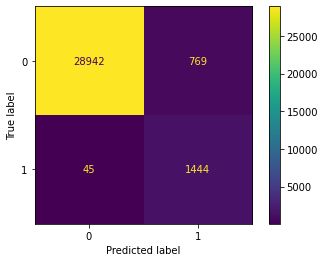

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot()

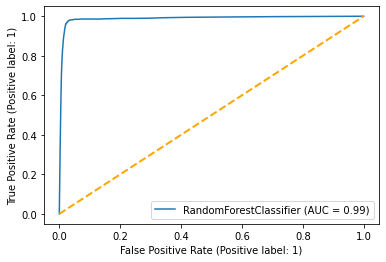

In [43]:
from sklearn.metrics import RocCurveDisplay
rfc_disp = RocCurveDisplay.from_estimator(rf_classifier, X_test, y_test)
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')

# Learning Technique #2: Sliding window with undersampling in training only

In [44]:
df.reset_index(drop=True, inplace=True)

In [45]:
# Specify the features (X) and the target variable (y)
X = df.drop(["timestamp", 
             "u", 
             "v", 
             "history_type", 
             "bip", 
             "cost", # cost of O1 features
             "history_size",
             "is_fraud",], axis="columns")
y = df["is_fraud"]

In [46]:
X

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,594.0,347.0,151.0,1.0,8.0,1.0,347.0,151.0,1.0,8.0,1.0,54.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,2.0,7.0,151.0,1.0,96.0,11.0,2.0,7.0,151.0,1.0,96.0,11.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
1,594.0,346.0,153.0,1.0,8.0,1.0,346.0,153.0,1.0,8.0,1.0,55.0,43.0,0.0,1.0,362.0,1.0,43.0,0.0,1.0,362.0,1.0,2.0,1.0,153.0,43.0,95.0,12.0,2.0,1.0,153.0,43.0,95.0,12.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
2,594.0,346.0,153.0,1.0,8.0,1.0,346.0,153.0,1.0,8.0,1.0,55.0,42.0,1.0,1.0,362.0,1.0,42.0,1.0,1.0,362.0,1.0,3.0,2.0,54.0,1.0,41.0,12.0,3.0,2.0,54.0,1.0,41.0,12.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
3,595.0,347.0,154.0,1.0,8.0,1.0,347.0,154.0,1.0,8.0,1.0,55.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,1.0,3.0,347.0,1.0,248.0,12.0,1.0,3.0,347.0,1.0,248.0,12.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
4,595.0,347.0,154.0,1.0,8.0,1.0,347.0,154.0,1.0,8.0,1.0,55.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,4.0,4.0,25.0,1.0,16.0,12.0,4.0,4.0,25.0,1.0,16.0,12.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103995,628.0,386.0,148.0,1.0,8.0,1.0,386.0,148.0,1.0,8.0,1.0,76.0,51.0,5.0,1.0,196.0,1.0,51.0,5.0,1.0,196.0,1.0,8.0,17.0,2.0,1.0,0.0,9.0,8.0,17.0,2.0,1.0,0.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
103996,627.0,385.0,148.0,1.0,8.0,1.0,385.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,4.0,18.0,14.0,1.0,8.0,9.0,4.0,18.0,14.0,1.0,8.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
103997,627.0,385.0,148.0,1.0,8.0,1.0,385.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,4.0,19.0,15.0,1.0,8.0,9.0,4.0,19.0,15.0,1.0,8.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
103998,628.0,386.0,148.0,1.0,8.0,1.0,386.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,1.0,20.0,386.0,1.0,242.0,9.0,1.0,20.0,386.0,1.0,242.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0


In [47]:
y

0         0
1         0
2         0
3         0
4         0
         ..
103995    0
103996    0
103997    0
103998    0
103999    0
Name: is_fraud, Length: 104000, dtype: int64

In [48]:
len(df) / 2

52000.0

In [49]:
8353+8350

16703

In [50]:
len(df)

104000

In [51]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

Delta: 1040 



In [52]:
len(df)

104000

In [53]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

roc_auc_results = []
c = 1

# Start the sliding window with overlap
for i in range(0, int(len(df) / 2), delta):
    b_i = i
    e_i = i + int(len(df) / 2)

    X_subset = X.iloc[b_i:e_i]
    y_subset = y.iloc[b_i:e_i]
    print(X_subset.index)

    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.3, shuffle=False)

    # Undersample the majority class (0) within each window
    X_train_sampled = pd.concat([X_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), X_train[y_train == 1]])
    y_train_sampled = pd.concat([y_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), y_train[y_train == 1]])

    # Compute counts of y = 1 and y = 0 for y_train
    y_train_1_count = sum(y_train_sampled == 1)
    y_train_0_count = sum(y_train_sampled == 0)
    
    # Compute counts of y = 1 and y = 0 for y_test
    y_test_1_count = sum(y_test == 1)
    y_test_0_count = sum(y_test == 0)
    
    print(f"Iteration {c}:")
    print(f"Counts of y = 1 and y = 0 in y_train: {y_train_1_count}, {y_train_0_count}")
    print(f"Counts of y = 1 and y = 0 in y_test: {y_test_1_count}, {y_test_0_count}")
    c += 1
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_sampled, y_train_sampled)
    y_pred = clf.predict(X_test)

    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    roc_auc_results.append(roc_auc)
    print(b_i)
    print(f"Iteration difference {e_i - b_i}: ROC-AUC={roc_auc:.4f}")
    print("------------------------------------------------------------------------------------------------")

average_roc_auc = sum(roc_auc_results) / len(roc_auc_results)

print(f"Average ROC-AUC: {average_roc_auc:.4f}")


Delta: 1040 

RangeIndex(start=0, stop=52000, step=1)
Iteration 1:
Counts of y = 1 and y = 0 in y_train: 1735, 1735
Counts of y = 1 and y = 0 in y_test: 771, 14829
0
Iteration difference 52000: ROC-AUC=0.9861
------------------------------------------------------------------------------------------------
RangeIndex(start=1040, stop=53040, step=1)
Iteration 2:
Counts of y = 1 and y = 0 in y_train: 1746, 1746
Counts of y = 1 and y = 0 in y_test: 761, 14839
1040
Iteration difference 52000: ROC-AUC=0.9843
------------------------------------------------------------------------------------------------
RangeIndex(start=2080, stop=54080, step=1)
Iteration 3:
Counts of y = 1 and y = 0 in y_train: 1762, 1762
Counts of y = 1 and y = 0 in y_test: 763, 14837
2080
Iteration difference 52000: ROC-AUC=0.9856
------------------------------------------------------------------------------------------------
RangeIndex(start=3120, stop=55120, step=1)
Iteration 4:
Counts of y = 1 and y = 0 in y_train: 1762

28080
Iteration difference 52000: ROC-AUC=0.9874
------------------------------------------------------------------------------------------------
RangeIndex(start=29120, stop=81120, step=1)
Iteration 29:
Counts of y = 1 and y = 0 in y_train: 1739, 1739
Counts of y = 1 and y = 0 in y_test: 709, 14891
29120
Iteration difference 52000: ROC-AUC=0.9860
------------------------------------------------------------------------------------------------
RangeIndex(start=30160, stop=82160, step=1)
Iteration 30:
Counts of y = 1 and y = 0 in y_train: 1742, 1742
Counts of y = 1 and y = 0 in y_test: 724, 14876
30160
Iteration difference 52000: ROC-AUC=0.9855
------------------------------------------------------------------------------------------------
RangeIndex(start=31200, stop=83200, step=1)
Iteration 31:
Counts of y = 1 and y = 0 in y_train: 1725, 1725
Counts of y = 1 and y = 0 in y_test: 732, 14868
31200
Iteration difference 52000: ROC-AUC=0.9867
------------------------------------------------

In [54]:
df.tail(2)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
103998,893286638,bottom_689,top_729,0,H,1000,True,0.0,628.0,386.0,148.0,1.0,8.0,1.0,386.0,148.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,1.0,20.0,386.0,1.0,242.0,9.0,1.0,20.0,386.0,1.0,242.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0
103999,893286638,bottom_748,top_729,0,H,1000,True,0.0,628.0,386.0,147.0,1.0,8.0,1.0,386.0,147.0,1.0,8.0,1.0,76.0,51.0,6.0,1.0,196.0,1.0,51.0,6.0,1.0,196.0,1.0,3.0,21.0,72.0,1.0,23.0,9.0,3.0,21.0,72.0,1.0,23.0,9.0,1000.0,1000.0,1000.0,0.0,1.0,1.0,1.0,1.0,1000.0,0.0


In [55]:
# Create a DataFrame
df2 = pd.DataFrame({"Values": roc_auc_results})

# Export DataFrame to Excel
df2.to_excel("MovieLens-5Perc-H1000-AUCInSlidingWindow.xlsx", index=False)

In [56]:
len(roc_auc_results)

50

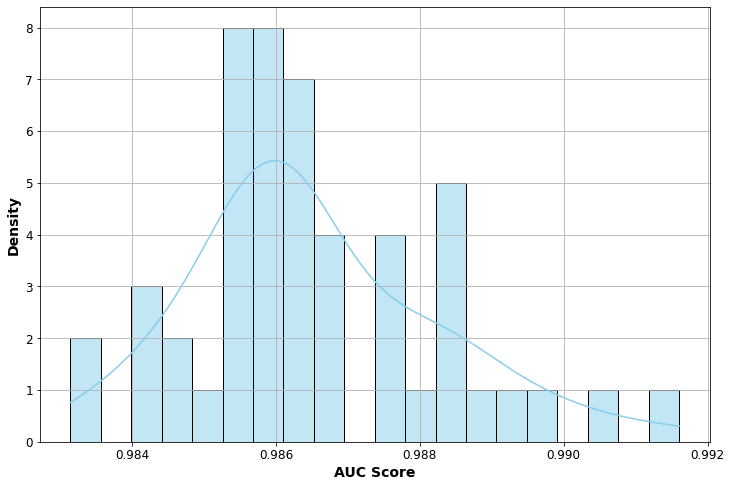

In [57]:
import seaborn as sns

# Plot the distribution with kernel density estimate
plt.figure(figsize=(12, 8))
sns.histplot(df2["Values"], kde=True, bins=20, color='skyblue')
plt.xlabel("AUC Score", fontsize=14,  fontweight='bold')
plt.ylabel("Density", fontsize=14,  fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()